In [99]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def create_new_dataset(original_ds, start_date='1970-01-01'):
    num_days = original_ds.dims['time']  # Assumendo che 'time' sia la dimensione temporale
    dates = pd.date_range(start=start_date, periods=num_days, freq='D')

    new_ds = xr.Dataset(
        {
            't2m': (('time', 'lat', 'lon'), np.full((num_days, len(original_ds['lat']), len(original_ds['lon'])), np.nan))
        },
        coords={
            'lat': original_ds['lat'],
            'lon': original_ds['lon'],
            'time': ('time', dates)
        }
    )
    
    new_ds['time'].attrs['units'] = 'days since 1970-01-01 00:00:00'
    #new_ds['t2m'].attrs = original_ds['t2m'].attrs  # Copia gli attributi se necessario

    return new_ds



def remove_annual_linear_trend(ds, trend_removed, variable, startdays):
    """ Rimuove il trend lineare globale da tutta la serie temporale di griglia per la variabile specificata. """
    #trend_removed = ds.copy()
    
    for lat in range(len(ds['lat'])):
        for lon in range(len(ds['lon'])):
            # Seleziona i dati per la lat e lon corrente
            y = ds[variable].isel(lat=lat, lon=lon)
            for dec in range(len(startdays)-1):
                annualy= y[startdays[dec]:startdays[dec+1]]
                if len(annualy.dropna('time')) > 1:  # Assicurati che ci siano almeno due punti dati per fare un fit
                    x = np.arange(len(annualy))
                    fit = np.polyfit(x, annualy, 1)  # Fit lineare
                    trend = np.polyval(fit, x)  # Calcola il trend
                    # Sottrai il trend dai dati
                    #print(trend_removed[variable][startdays[dec]:startdays[dec+1], lat, lon])
                    trend_removed[variable][startdays[dec]:startdays[dec+1], lat, lon] = trend
                    print(trend_removed[variable][startdays[dec], lat, lon])

    return trend_removed

### altra prova, non va
'''def remove_annual_linear_trend(ds, variable):  
    """Rimuove il trend lineare annuale da ogni serie temporale di griglia per la variabile specificata."""
    trend_removed = ds.copy()
    years = range(1970, 2022)
    for year in years:
        sudd = new_ds.sel(time = str(year))
        for lat in range(len(new_ds['lat'])):
            for lon in range(len(new_ds['lon'])):
                # Seleziona i dati per l'anno, lat e lon corrente
                y = sudd[variable].isel(lat=lat, lon=lon)
                    
                if len(y.dropna(dim='time')) > 3:  # Evita anni con un solo dato o senza dati
                    # Fit lineare
                    x = np.arange(len(y))
                    fit = np.polyfit(x, y['t2m'].values, 1)
                    trend = np.polyval(fit, x)
                    
                    # Calcola gli indici di tempo per l'anno corrente per applicare la correzione
                    time_indices = ds.sel(time=str(year)).time

                    # Sottrai il trend dai dati originali
                    trend_removed[variable].loc[dict(time=time_indices, lat=ds['lat'][lat], lon=ds['lon'][lon])] -= trend

    return trend_removed'''


def remove_global_linear_trend(ds, variable):
    """ Rimuove il trend lineare globale da tutta la serie temporale di griglia per la variabile specificata. """
    trend_removed = ds.copy()
    
    for lat in range(len(ds['lat'])):
        for lon in range(len(ds['lon'])):
            # Seleziona i dati per la lat e lon corrente
            y = ds[variable].isel(lat=lat, lon=lon)
            if len(y.dropna('time')) > 1:  # Assicurati che ci siano almeno due punti dati per fare un fit
                x = np.arange(len(y))
                fit = np.polyfit(x, y, 1)  # Fit lineare
                trend = np.polyval(fit, x)  # Calcola il trend
                
                # Sottrai il trend dai dati
                trend_removed[variable][:, lat, lon] -= trend

    return trend_removed

def compute_anomalies(ds, VARIABLE, BASELINE_INTERVAL):
    start, end = BASELINE_INTERVAL
    ds = ds[VARIABLE]
    ds_baseline = ds.sel(time=(ds['time.year'] >= start) & (ds['time.year'] <= end))
    
    gb = ds_baseline.groupby('time.dayofyear')
    clim = gb.mean(dim='time')
    std_clim = gb.std(dim='time')
    
    clim_time = clim.sel(dayofyear=ds.time.dt.dayofyear)
    std_clim_time = std_clim.sel(dayofyear=ds.time.dt.dayofyear)

    anomalies = (ds - clim_time)
    return anomalies






# Carica il dataset originale
original_ds = xr.open_dataset("D:/HD climatenetwork/PAPER/t2m_1970_2022_5grid.nc")
new_ds = create_new_dataset(original_ds)
new_ds['t2m'].loc[:,:,:] = original_ds['t2m']

# anomalie baseline 1970, 1989
BASELINE_INTERVAL = [1970, 1989]
anomalies_bs7089 = compute_anomalies(new_ds, 't2m', BASELINE_INTERVAL)

# anomalie baseline 1970, 2021
BASELINE_INTERVAL2 = [1970, 2021]
anomalies_bs7021 = compute_anomalies(new_ds, 't2m', BASELINE_INTERVAL2)

# anomalie rimozione trend lineare globale 
new_ds_no_global_trend = remove_global_linear_trend(new_ds, 't2m')
anomalies_no_global_trend = compute_anomalies(new_ds_no_global_trend, 't2m', BASELINE_INTERVAL)

#### bisogna ricaricare il dataset perche viene modificato, anche qui non so perche...
# anomalie rimozione trend lineare annuale 

original_ds = xr.open_dataset("D:/HD climatenetwork/PAPER/t2m_1970_2022_5grid.nc")
new_ds = create_new_dataset(original_ds)
new_ds['t2m'].loc[:,:,:] = original_ds['t2m']

max_lag = 200         
start_year = 1970
end_year = 2022

start_days = []    ### ho fatto la prova mettendo io gli indici
    
current_day = 0  # 1 jan 2022
for year in range(start_year, end_year + 1):
        
    start_days.append(current_day)
    if (year % 4 == 0 and year % 100 != 0) or (year % 400 == 0):
        days_in_year = 366
    else:
        days_in_year = 365
    current_day += days_in_year 
last_day_index = 19358
#last_day_index = 28854
start_days.append(last_day_index) 


trend_removed = create_new_dataset(original_ds)
new_ds_no_annual_trend = remove_annual_linear_trend(new_ds, trend_removed, 't2m', start_days)
result_ds = new_ds - new_ds_no_annual_trend
anomalies_no_annual_trend = compute_anomalies(result_ds, 't2m', BASELINE_INTERVAL)'''

C:\Users\David\AppData\Roaming\Python\Python311\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\David\AppData\Roaming\Python\Python311\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\David\AppData\Roaming\Python\Python311\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\David\AppData\Roaming\Python\Python311\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\David\AppData\Roaming\Python\Python311\site-packages\numpy\lib\nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis

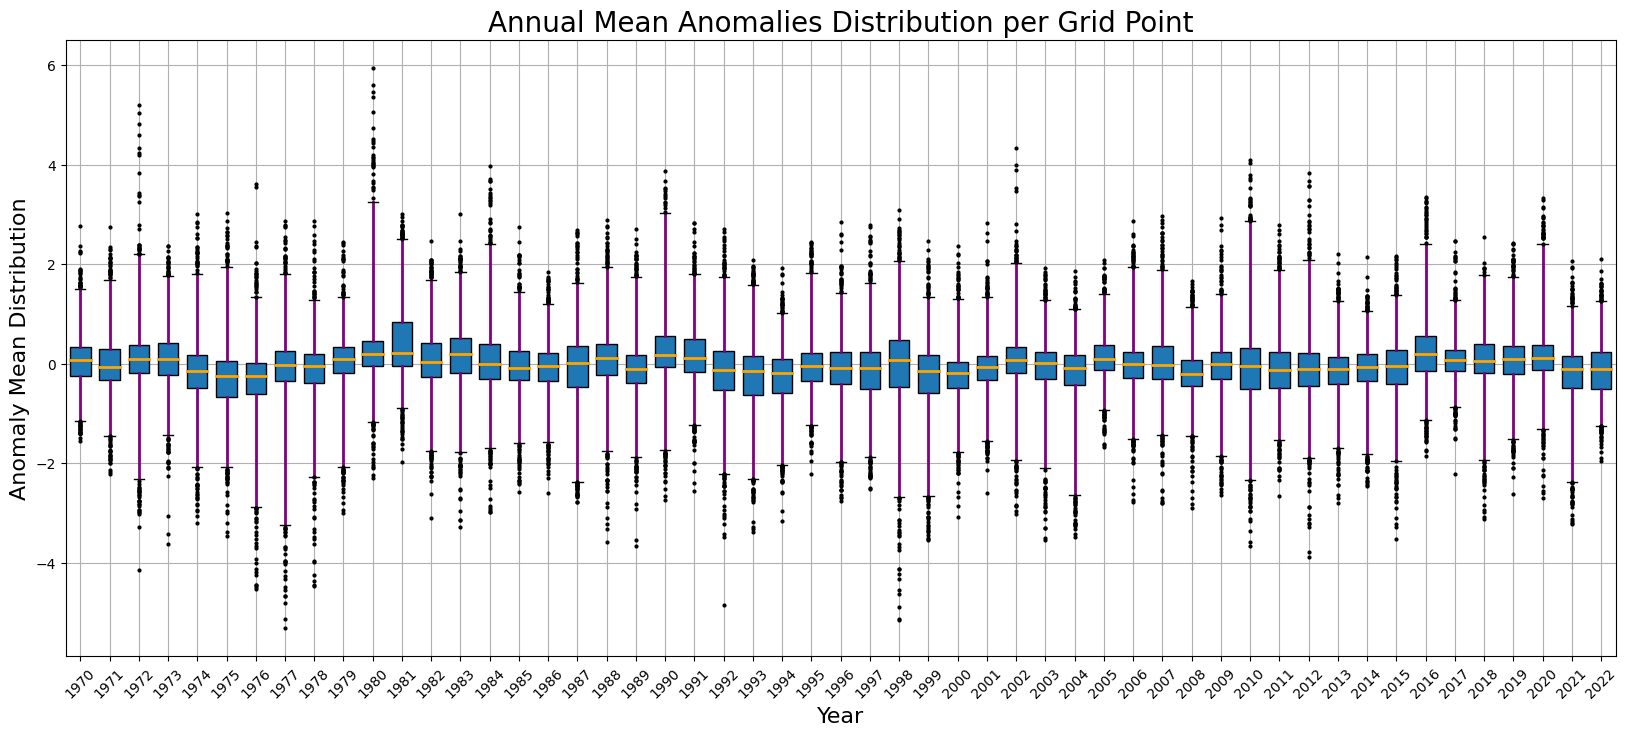

In [102]:
def plot_annual_anomaly_distribution(anomalies):
    """
    Plotta le distribuzioni annuali delle anomalie per ogni punto di griglia utilizzando uno stile grafico specifico.
    
    Args:
    - anomalies (xarray.DataArray): DataArray contenente le anomalie calcolate, con coordinate di 'time', 'lat' e 'lon'.
    """
    # Calcola la media annuale delle anomalie per ogni latitudine e longitudine
    annual_anomaly_means = anomalies.groupby('time.year').mean()

    years = range(1970, 2023)

    # Estrai i dati per il boxplot e crea un dizionario
    data_dict = {year: annual_anomaly_means.sel(year=year).values.flatten() for year in years}

    # Creazione del boxplot con stile specifico
    plt.figure(figsize=(20, 8))
    bp = plt.boxplot(list(data_dict.values()), patch_artist=True, widths=0.7, whis=[1, 99],
                     whiskerprops={'color': 'purple', 'linewidth': 2},
                     flierprops={'marker': 'o', 'markersize': 2, 'markerfacecolor': 'k', 'markeredgecolor': 'k'},
                     medianprops={'color': 'orange', 'linewidth': 2})

    # Impostazioni del titolo e delle etichette
    plt.title('Annual Mean Anomalies Distribution per Grid Point', fontsize=20)
    plt.xlabel('Year', fontsize=16)
    plt.ylabel('Anomaly Mean Distribution', fontsize=16)

    # Impostazioni degli assi
    plt.xticks(ticks=np.arange(1, len(data_dict) + 1), labels=list(data_dict.keys()), rotation=45)
    plt.grid(True)
    plt.show()


plot_annual_anomaly_distribution(anomalies_no_global_trend)